https://dacon.io/competitions/official/235584/data/

※데이터 설명

-  대전지역에서 측정한 실내외 19곳의 센서데이터와, 주변 지역의 기상청 공공데이터를 semi-비식별화하여 제공합니다.
-  센서는 온도를 측정하였습니다.
-  모든 데이터는 시간 순으로 정렬 되어 있으며 10분 단위 데이터 입니다.
-  예측 대상(target variable)은 Y18입니다.


●train.csv 

- 30일 간의 기상청 데이터 (X00~X39) 및 센서데이터 (Y00~Y17)
- 이후 3일 간의 기상청 데이터 (X00~X39) 및 센서데이터 (Y18)

●test.csv 

- train.csv 기간 이후 80일 간의 기상청 데이터 (X00~X39)

●sample_submission.csv

- 제출 양식 예시

# Library 호출 및 , 한글 시각화

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import time
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
sns.set_style("whitegrid")


#한글 시각화
from matplotlib import font_manager, rc

font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
matplotlib.rcParams['axes.unicode_minus'] = False

# 데이터 불러오기

In [2]:
path = 'C:/Users/병현/Desktop/데이콘/온도2020_03/AIFrenz_Season1_dataset/'

submission = pd.read_csv(path + 'sample_submission.csv', index_col = 0)
train = pd.read_csv(path + 'train.csv', index_col = 0)
test = pd.read_csv(path + 'test.csv', index_col = 0)
train.head()

,X00,X01,X02,X03,X04,X05,X06,X07,X08,X09,...,Y09,Y10,Y11,Y12,Y13,Y14,Y15,Y16,Y17,Y18
id,,,,,,,,,,,,,,,,,,,,,
0,9.7,988.8,1.2,0.6,0.0,1009.3,989.6,12.2,1009.9,1009.8,...,7.0,7.5,7.0,9.0,10.0,9.5,9.0,8.0,9.0,NaN
1,9.3,988.9,1.7,1.9,0.0,1009.3,989.6,12.1,1010.0,1009.9,...,6.5,7.5,7.0,8.5,10.0,9.5,9.0,7.5,9.0,NaN
2,9.4,989.0,1.1,2.3,0.0,1009.2,989.7,12.1,1010.1,1010.1,...,6.5,7.5,6.5,8.0,9.5,9.5,8.5,7.5,8.5,NaN
3,9.4,988.9,1.5,0.7,0.0,1009.2,989.6,12.0,1010.0,1010.0,...,6.0,7.0,6.0,8.0,9.5,9.0,8.5,7.5,8.5,NaN
4,9.2,988.9,0.8,1.7,0.0,1009.2,989.7,12.0,1010.1,1010.0,...,6.0,7.0,6.0,7.5,9.5,9.0,8.5,7.5,8.5,NaN


# 데이터 Column 정리
○ 주어진 데이터가 너무 지저분하게 주어짐. 이를 보기좋게 정리가 필요

○ 큰 분류로 
1. 기온   / 2. 현지기압 / 3. 풍속 / 4. 일일누적강수량 / 5. 해면기압 / 6. 일일누적일사량 / 7. 습도 / 8. 풍향 / 9. 관측소Y00~Y18

○ 각 변수별 측정 위치를 맞춰 놓을 수가 없게 랜덤하게 주어짐

In [3]:
column_index = ['기온','현지기압','풍속','일일누적강수량','해면기압','일일누적일사량','습도','풍향']

train = train.iloc[:, [0,7,28,31,32,  #기온
                       1,6,22,27,29,  #현지기압
                       2,3,18,24,26,  #풍속
                       4,10,21,36,39, #일일누적강수량
                       5,8,9,23,33,   #해면기압
                       11,14,16,19,34,#일일누적일사량
                       12,20,30,37,38,#습도
                       13,15,17,25,35,#풍향
                       40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58]] # Y , 관측소

test = test.iloc[:, [0,7,28,31,32,
                     1,6,22,27,29,
                     2,3,18,24,26,
                     4,10,21,36,39,
                     5,8,9,23,33,11,
                     14,16,19,34,12,
                     20,30,37,38,13,
                     15,17,25,35]]

df_col_index = []
for col in column_index:
    df_col_index += [col + '%02d'%i for i in range(1,6)]
    
train.columns = df_col_index + ['Y%02d'%i for i in range(19)]
test.columns = df_col_index
train

,기온01,기온02,기온03,기온04,기온05,현지기압01,현지기압02,현지기압03,현지기압04,현지기압05,...,Y09,Y10,Y11,Y12,Y13,Y14,Y15,Y16,Y17,Y18
id,,,,,,,,,,,,,,,,,,,,,
0,9.7,12.2,12.3,8.2,10.7,988.8,989.6,1002.5,1008.7,1001.6,...,7.0,7.5,7.0,9.0,10.0,9.5,9.0,8.0,9.0,NaN
1,9.3,12.1,12.1,8.3,10.3,988.9,989.6,1002.5,1008.7,1001.7,...,6.5,7.5,7.0,8.5,10.0,9.5,9.0,7.5,9.0,NaN
2,9.4,12.1,12.1,8.0,9.7,989.0,989.7,1002.4,1008.6,1001.6,...,6.5,7.5,6.5,8.0,9.5,9.5,8.5,7.5,8.5,NaN
3,9.4,12.0,12.1,7.7,9.4,988.9,989.6,1002.4,1008.7,1001.5,...,6.0,7.0,6.0,8.0,9.5,9.0,8.5,7.5,8.5,NaN
4,9.2,12.0,12.0,7.4,9.4,988.9,989.7,1002.4,1008.7,1001.5,...,6.0,7.0,6.0,7.5,9.5,9.0,8.5,7.5,8.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4747,19.9,21.7,23.8,17.7,19.1,987.6,987.7,1000.4,1006.0,999.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.5
4748,19.9,21.6,23.6,17.7,19.2,987.6,987.7,1000.3,1006.0,999.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.5
4749,19.7,21.4,23.6,17.8,19.2,987.7,987.6,1000.4,1006.0,999.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.5


# 데이터 파악 

In [4]:
print('train data\'s shape = ' , train.shape) 
print('test data\'s shape = ' , test.shape) 


# 왜 열의 개수가 19개나 차이가 나는지를 명확히 알아야함.
print('\n\n train 데이터 와 test 데이터에서 Column의 차집합\n', 
      set(train.columns) - set(test.columns))

train data's shape =  (4752, 59)
test data's shape =  (11520, 40)


 train 데이터 와 test 데이터에서 Column의 차집합
 {'Y07', 'Y16', 'Y00', 'Y10', 'Y17', 'Y04', 'Y13', 'Y09', 'Y02', 'Y08', 'Y15', 'Y06', 'Y18', 'Y11', 'Y01', 'Y03', 'Y14', 'Y05', 'Y12'}


○ train데이터에는 Y00~ Y18 값인 센서 온도 측정값이 존재한다.

○ train데이터의 행은 총 4752개로 , 
       Y00 ~ Y17 존재하는 행 : 4320개의 행
       Y18만 존재하는 행     : 432개의 행으로 이루어져 있다 .
       
○ 현재우리의 목표는 test데이터의 변수들을 통해 , Y18값을 예측하는 것이다 . 

○ 또한 ,train데이터에서 Y18이 NaN인 값이 상당히 많은데(4752개의 행중 , 4352개의 행) , 
   Y18이 NaN인 행은 Y00~Y17를 통해 Y18값을 대체해줘야함 .
   이 과정이 가장 중요하다고 생각되며 , Y18값이 없는 행에 대해 Y18값을 어떻게 대체해줄 수 있는지에 대해 많은 생각이 필요함.

In [5]:
train[train['Y00'].isna()]

,기온01,기온02,기온03,기온04,기온05,현지기압01,현지기압02,현지기압03,현지기압04,현지기압05,...,Y09,Y10,Y11,Y12,Y13,Y14,Y15,Y16,Y17,Y18
id,,,,,,,,,,,,,,,,,,,,,
4320,19.3,20.8,21.0,18.0,18.7,987.7,988.0,1001.1,1006.7,1000.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.5
4321,19.0,20.6,20.7,17.7,19.0,987.6,988.0,1001.1,1006.7,1000.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.5
4322,19.1,20.5,20.7,17.4,19.2,987.6,988.1,1001.2,1006.7,1000.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.5
4323,19.2,20.5,20.6,17.5,19.3,987.7,988.1,1001.3,1006.8,1000.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.5
4324,19.2,20.5,20.5,17.4,19.5,987.8,988.1,1001.3,1006.8,1000.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4747,19.9,21.7,23.8,17.7,19.1,987.6,987.7,1000.4,1006.0,999.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.5
4748,19.9,21.6,23.6,17.7,19.2,987.6,987.7,1000.3,1006.0,999.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.5
4749,19.7,21.4,23.6,17.8,19.2,987.7,987.6,1000.4,1006.0,999.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.5


In [6]:
train[train['Y18'].isna()]

,기온01,기온02,기온03,기온04,기온05,현지기압01,현지기압02,현지기압03,현지기압04,현지기압05,...,Y09,Y10,Y11,Y12,Y13,Y14,Y15,Y16,Y17,Y18
id,,,,,,,,,,,,,,,,,,,,,
0,9.7,12.2,12.3,8.2,10.7,988.8,989.6,1002.5,1008.7,1001.6,...,7.0,7.5,7.0,9.0,10.0,9.5,9.0,8.0,9.0,NaN
1,9.3,12.1,12.1,8.3,10.3,988.9,989.6,1002.5,1008.7,1001.7,...,6.5,7.5,7.0,8.5,10.0,9.5,9.0,7.5,9.0,NaN
2,9.4,12.1,12.1,8.0,9.7,989.0,989.7,1002.4,1008.6,1001.6,...,6.5,7.5,6.5,8.0,9.5,9.5,8.5,7.5,8.5,NaN
3,9.4,12.0,12.1,7.7,9.4,988.9,989.6,1002.4,1008.7,1001.5,...,6.0,7.0,6.0,8.0,9.5,9.0,8.5,7.5,8.5,NaN
4,9.2,12.0,12.0,7.4,9.4,988.9,989.7,1002.4,1008.7,1001.5,...,6.0,7.0,6.0,7.5,9.5,9.0,8.5,7.5,8.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4315,19.5,21.3,21.6,18.8,19.4,987.8,988.0,1001.2,1006.6,1000.1,...,19.5,20.0,19.0,20.5,20.5,20.0,20.0,20.5,20.0,NaN
4316,19.3,21.3,21.6,18.6,18.5,987.7,988.1,1001.2,1006.8,1000.1,...,19.5,20.0,19.0,20.5,20.5,20.0,19.5,20.5,19.5,NaN
4317,19.5,21.2,21.5,18.4,19.1,987.8,988.3,1001.2,1006.8,1000.2,...,19.5,20.0,19.0,20.0,20.0,19.5,19.5,20.0,19.0,NaN


# 관측소 센서별 Y18과의 상관관계 파악 

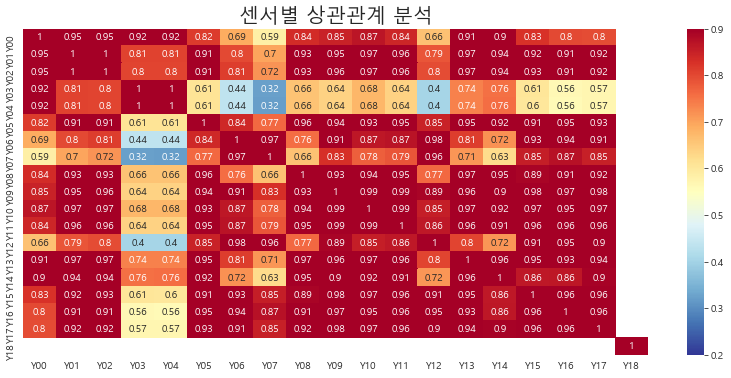

In [7]:
sensor_col = ['Y%02d'%n for n in range(0,19)]
train_sensor_temp = train[sensor_col]

plt.figure(figsize = (14,6))
sns.heatmap(train_sensor_temp.corr(), cmap = plt.cm.RdYlBu_r, vmin = 0.2,  vmax = 0.9, annot=True)
plt.title('센서별 상관관계 분석', fontsize=20)

plt.show()

- Y03과 Y04는 Y18과 상관관계가 비교적 매우 낮음.
- Y03과 Y04는 Y18을 예측하는데에 방해가 될 요소라 생각되서 지워도 괜찮다고 생각됨

In [8]:
train = train.drop( columns = ['Y03', 'Y04'] )
sensor_col.remove('Y03') ; sensor_col.remove('Y04')

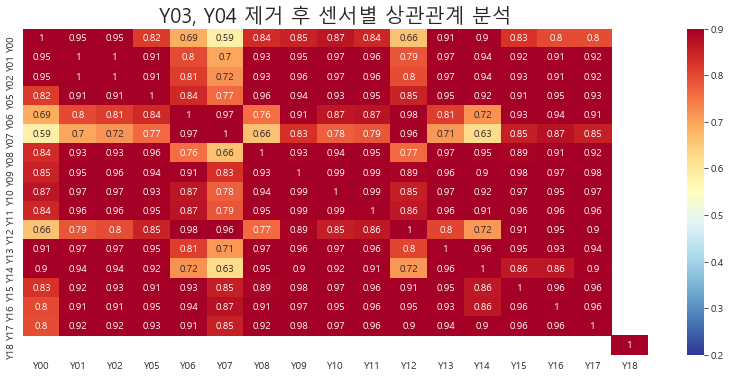

In [9]:
train_sensor_temp_Drop = train[sensor_col]

plt.figure(figsize = (14,6))
sns.heatmap(train_sensor_temp_Drop.corr(), cmap = plt.cm.RdYlBu_r, vmin = 0.2,  vmax = 0.9, annot=True)
plt.title('Y03, Y04 제거 후 센서별 상관관계 분석', fontsize=20)

plt.show()
#Y03과 Y04를 제거후에는 모든 관측소 센서온도값은 Y18과 상관성 높음을 볼 수 있다.

# 분석 전에 구하고자 하는 label 인 Y18과 변수의 상관관계 확인 

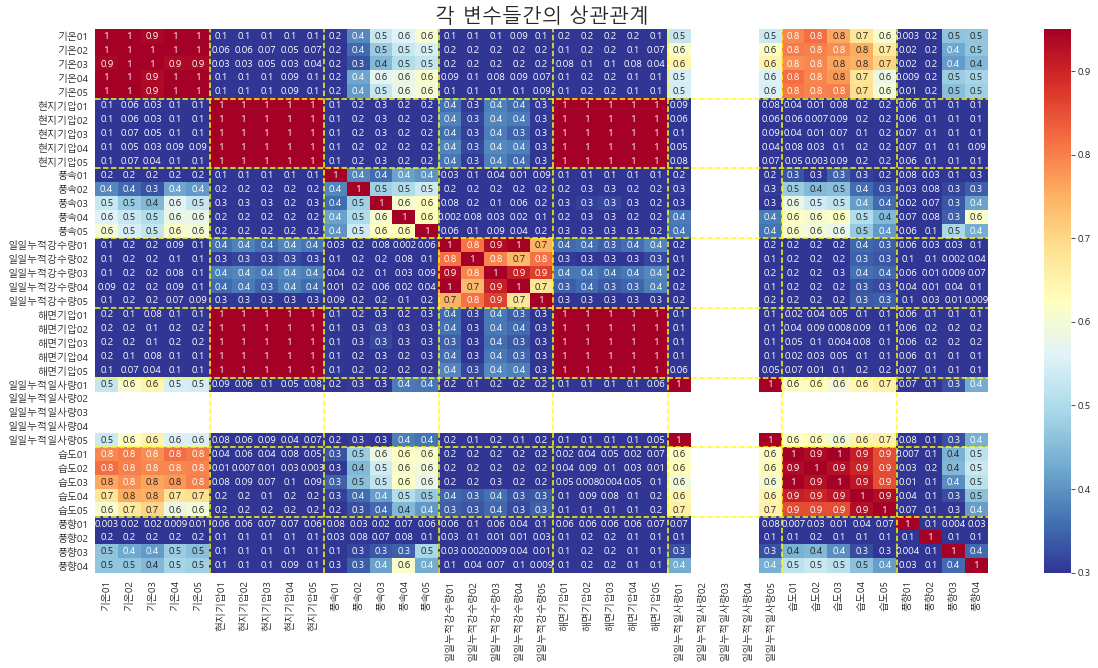

In [10]:
plt.figure(figsize = (20,10))
sns.heatmap(abs(train.loc[:'풍향04',:'풍향04'].corr()) ,cmap = plt.cm.RdYlBu_r, vmin = 0.3,  vmax = 0.95, annot=True, fmt='.1g')
plt.title('각 변수들간의 상관관계', fontsize = 20)
for i in range(7):
    plt.axvline(5 + 5*i, color = 'yellow' , linestyle = '--')
    plt.axhline(5 + 5*i, color = 'yellow' , linestyle = '--')
plt.show()

○ 같은 변수명을 가진 변수끼리는 상관관계가 매우 높음 .

○ 해면기압과 현지기압은 상관관계가 너무 크므로 , 다중공선성의 문제가 생기므로 하나를 버려야 더 좋은 결과 나옴(해면기압을 버리기로함)

○ 일일 누적일사량은 02, 03, 04값이 상관계수가 전혀 존재하지 않음 . 이 센서값을 확인해보니 모두 이상한값이 들어가있음. 

   일일누적일사량02~04 데이터는 고장났다고 판단

In [11]:
train

,기온01,기온02,기온03,기온04,기온05,현지기압01,현지기압02,현지기압03,현지기압04,현지기압05,...,Y09,Y10,Y11,Y12,Y13,Y14,Y15,Y16,Y17,Y18
id,,,,,,,,,,,,,,,,,,,,,
0,9.7,12.2,12.3,8.2,10.7,988.8,989.6,1002.5,1008.7,1001.6,...,7.0,7.5,7.0,9.0,10.0,9.5,9.0,8.0,9.0,NaN
1,9.3,12.1,12.1,8.3,10.3,988.9,989.6,1002.5,1008.7,1001.7,...,6.5,7.5,7.0,8.5,10.0,9.5,9.0,7.5,9.0,NaN
2,9.4,12.1,12.1,8.0,9.7,989.0,989.7,1002.4,1008.6,1001.6,...,6.5,7.5,6.5,8.0,9.5,9.5,8.5,7.5,8.5,NaN
3,9.4,12.0,12.1,7.7,9.4,988.9,989.6,1002.4,1008.7,1001.5,...,6.0,7.0,6.0,8.0,9.5,9.0,8.5,7.5,8.5,NaN
4,9.2,12.0,12.0,7.4,9.4,988.9,989.7,1002.4,1008.7,1001.5,...,6.0,7.0,6.0,7.5,9.5,9.0,8.5,7.5,8.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4747,19.9,21.7,23.8,17.7,19.1,987.6,987.7,1000.4,1006.0,999.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.5
4748,19.9,21.6,23.6,17.7,19.2,987.6,987.7,1000.3,1006.0,999.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.5
4749,19.7,21.4,23.6,17.8,19.2,987.7,987.6,1000.4,1006.0,999.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.5


In [12]:
#다중공선성 문제 미리 막기 위해 해면기압 열 삭제
train.drop(['해면기압%02d'%i for i in range(1,6)] , axis = 1 , inplace = True)
test.drop(['해면기압%02d'%i for i in range(1,6)] , axis = 1 , inplace = True)

column_index.remove('해면기압')

In [13]:
#일일누적일사량02, 03, 04 센서 고장났다고 판단해서 삭제
train.drop(['일일누적일사량%02d'%i for i in range(2,5)], axis = 1 , inplace = True)
test.drop(['일일누적일사량%02d'%i for i in range(2,5)], axis = 1 , inplace = True)

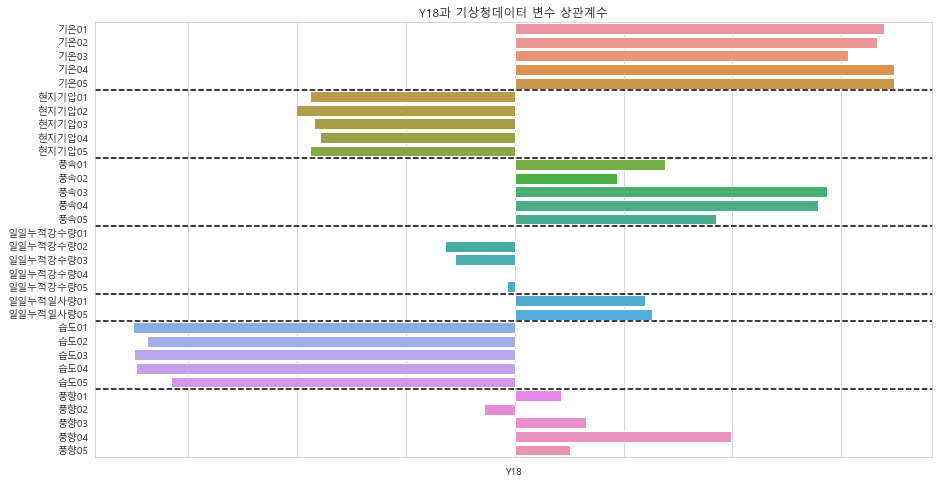

In [14]:
plt.figure(figsize = (15,8))
ax = sns.barplot(y = train.loc[4320:,:].corr().loc[:'풍향05','Y18'].index , x = train.loc[4320:,:].corr().loc[:'풍향05','Y18'])
ax.set_xticklabels(ax.get_xticklabels() ,rotation=90)

ax.set_title('Y18과 기상청데이터 변수 상관계수')

plt.axhline(4.5 , linestyle ='--', color ='black');plt.axhline(9.5 , linestyle ='--', color ='black');
plt.axhline(14.5 , linestyle ='--', color ='black');plt.axhline(19.5 , linestyle ='--', color ='black');
plt.axhline(21.5 , linestyle ='--', color ='black');plt.axhline(26.5 , linestyle ='--', color ='black');


plt.show()

# 시간 변수 추가  (10분주기 : time , 1시간주기 : hour)

○ 시간별 온도 , 습도 등 파악하는데 유용할것

○ train 데이터는 30일(Y18 결측) + 3일(Y18만 존재)한 행으로 33일치를 관측한것이고
   test 데이터는 그 이후의 80일을 관측한 데이터이다 . 
   
○ 한 행마다 10분 주기로 측정된 데이터이다.

○ 하지만 온도로 보아서는 여름임을 짐작 할 순 있지만 , 정확히 몇월인지는 알아내기 힘들다 .
   알아낸다 하더라도 , 외부데이터 사용을 제한한 대회라 구체적인 날짜는 의미 없을것이라 생각함

In [15]:
#----------------train , test 데이터프레임에    time 데이터 추가
train['time'] = pd.date_range('00:00:00', periods=len(train), freq='10min')
test['time'] = pd.date_range('00:00:00', periods=len(test), freq='10min')

train['time'] = train['time'].apply(lambda x : x.strftime('%H:%M'))
test['time'] = test['time'].apply(lambda x : x.strftime('%H:%M'))


#----------------train , test 데이터프레임에   hour 데이터 추가
train['hour'] = train['time'].str[:2].astype(int)
test['hour'] = test['time'].str[:2].astype(int)

train.head()

#time변수와 hour 변수 추가됨을 볼 수 있다. 

,기온01,기온02,기온03,기온04,기온05,현지기압01,현지기압02,현지기압03,현지기압04,현지기압05,...,Y11,Y12,Y13,Y14,Y15,Y16,Y17,Y18,time,hour
id,,,,,,,,,,,,,,,,,,,,,
0,9.7,12.2,12.3,8.2,10.7,988.8,989.6,1002.5,1008.7,1001.6,...,7.0,9.0,10.0,9.5,9.0,8.0,9.0,NaN,00:00,0
1,9.3,12.1,12.1,8.3,10.3,988.9,989.6,1002.5,1008.7,1001.7,...,7.0,8.5,10.0,9.5,9.0,7.5,9.0,NaN,00:10,0
2,9.4,12.1,12.1,8.0,9.7,989.0,989.7,1002.4,1008.6,1001.6,...,6.5,8.0,9.5,9.5,8.5,7.5,8.5,NaN,00:20,0
3,9.4,12.0,12.1,7.7,9.4,988.9,989.6,1002.4,1008.7,1001.5,...,6.0,8.0,9.5,9.0,8.5,7.5,8.5,NaN,00:30,0
4,9.2,12.0,12.0,7.4,9.4,988.9,989.7,1002.4,1008.7,1001.5,...,6.0,7.5,9.5,9.0,8.5,7.5,8.5,NaN,00:40,0


# EDA 데이터 탐색적 분석 (기상청 데이터)

In [16]:
print('분석이 필요한 변수들 : ', column_index)

분석이 필요한 변수들 :  ['기온', '현지기압', '풍속', '일일누적강수량', '일일누적일사량', '습도', '풍향']


○ train 데이터의 기상청 데이터변수 시각화

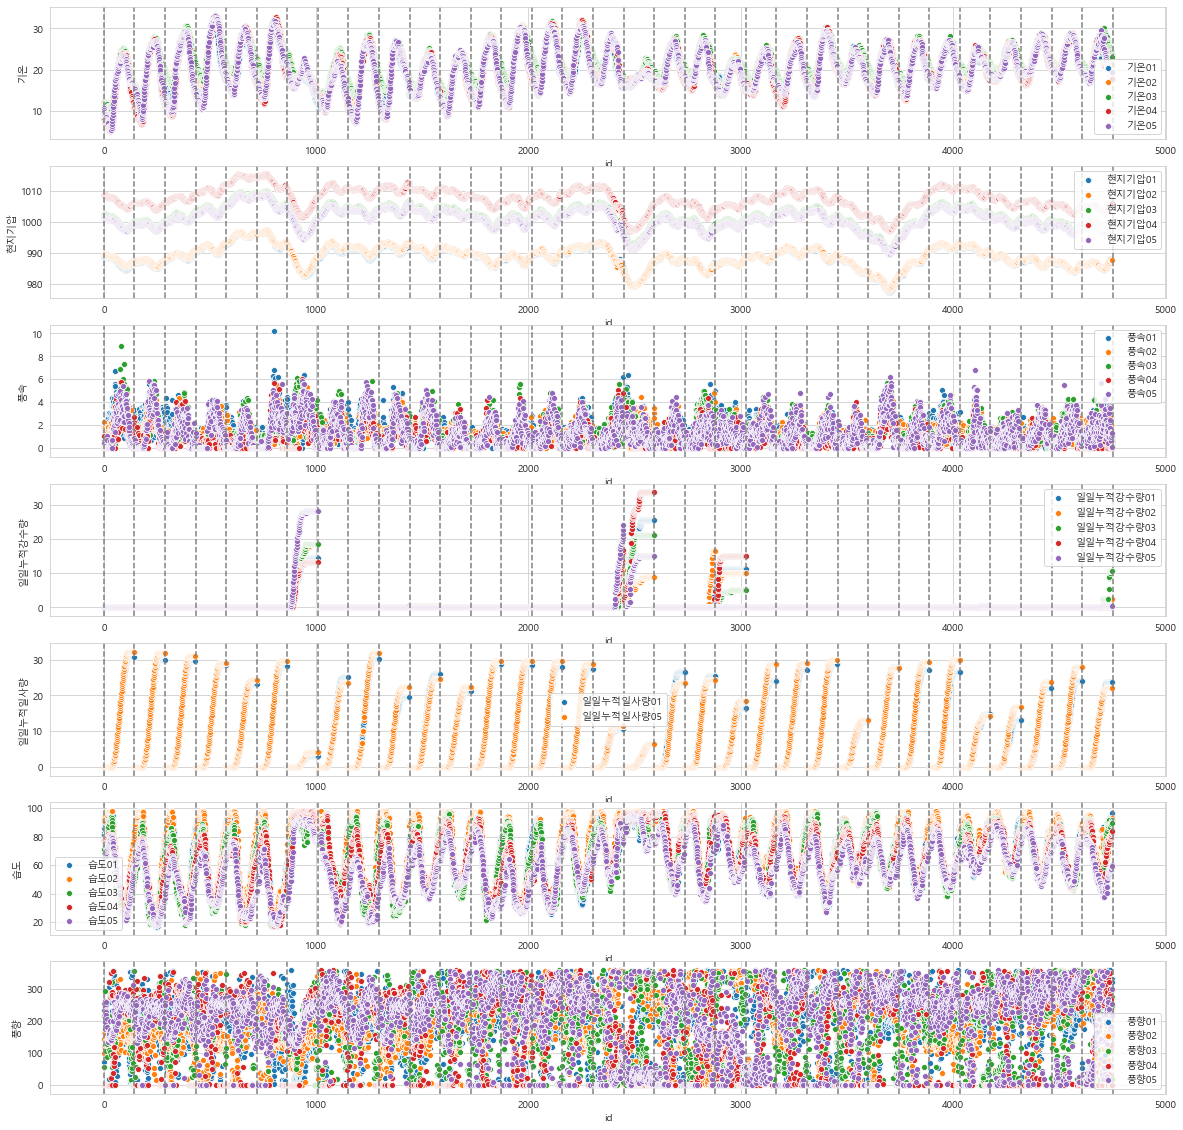

In [17]:
fig, ax = plt.subplots(nrows = len(column_index), ncols = 1, figsize = (20,20))

for index , col in enumerate(column_index):
    #plt.figure(figsize = (20,5))
    for i in range(1,6):
        try:        #일일누적일사량02, 03, 04값을 지워서 나타나는 에러 해결위해 예외처리 사용함
            sns.scatterplot(train.index , train[col + '%02d'%i] , label = col + '%02d'%i, ax = ax[index])
        except:
            pass
    ax[index].set_ylabel(col)

    for i in range(34):
        ax[index].axvline(144*i , color = 'gray' , linestyle = '--')
    
    
# 수직 점선은 하루를 단위로 표현함

○ 기상청 변수 시간별로 시각화

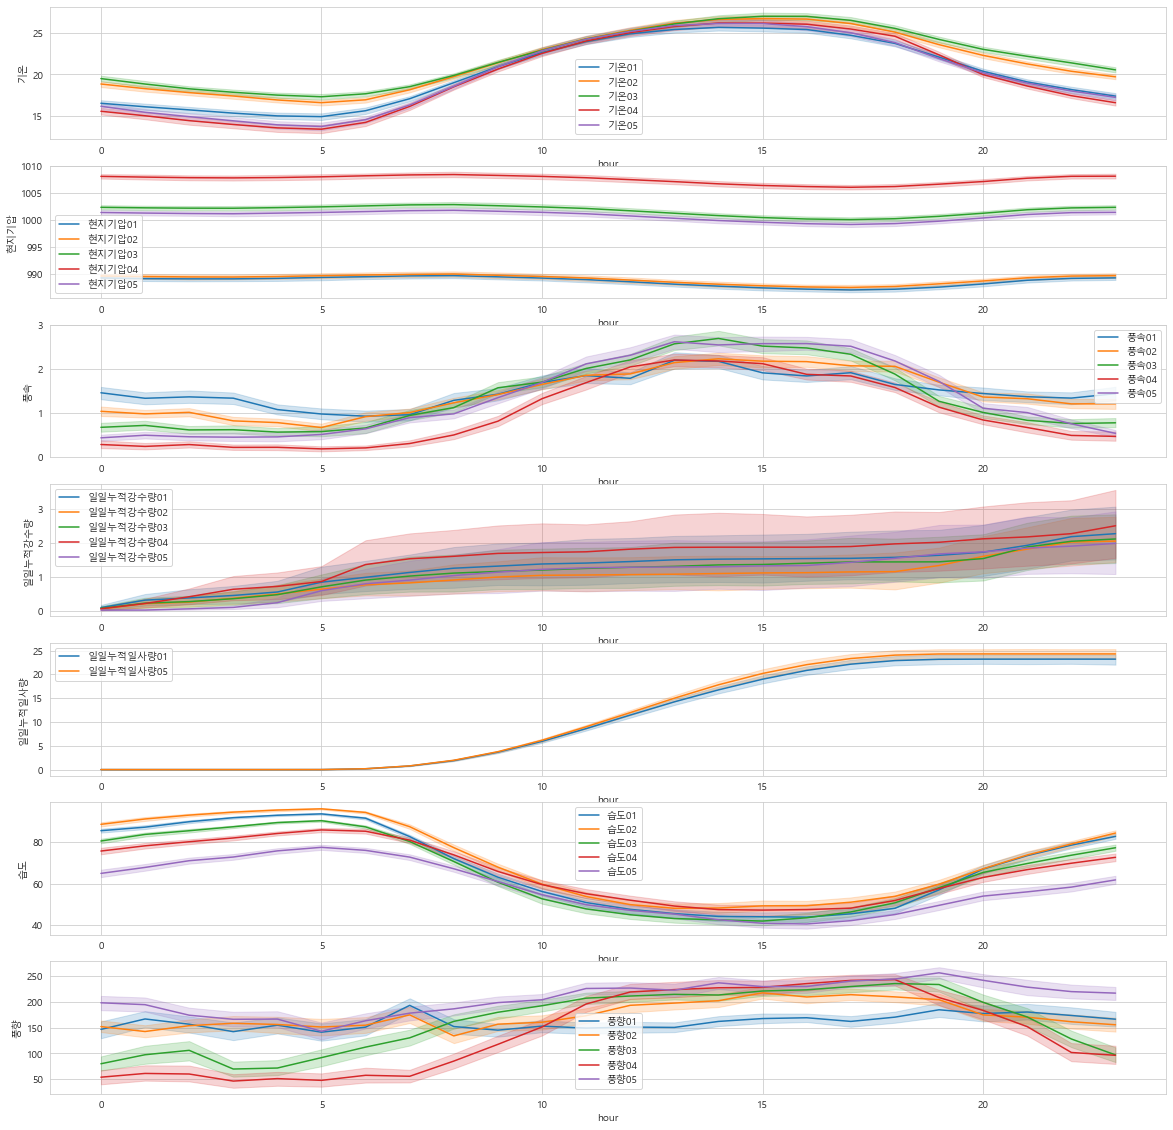

In [18]:
fig, ax = plt.subplots(nrows = len(column_index), ncols = 1, figsize = (20,20))

for index , col in enumerate(column_index):
    #plt.figure(figsize = (20,5))
    for i in range(1,6):
        try:            #예외처리는 일일누적일사량이 02, 03, 04값이 없어서 사용함
            sns.lineplot(x = 'hour' , y = col + '%02d'%i , data = train, label = col + '%02d'%i, ax = ax[index])
        except:
            pass
    ax[index].set_ylabel(col)
    
    
# 수직 점선은 하루를 단위로 표현함

○ Y18은 일교차가 비교적 적은편임을 알 수 있다. 
   그리고 , 중간값과 최저온도 또한 큰 차이가 없다는 점을 알 수 있다.

○ 이 데이터는 대전 지역의 기상청 데이터이므로 , 아무래도 한 지역의 데이터이다보니
   (기온, 누적일사량, 누적강수량,습도)의 차이는 크지 않음을 볼 수 있다 . 
   이 데이터들은 그냥 평균값을 내주어서 사용하기로 함


○ 하지만 (현지기압 , 풍향, 풍속) 은 어느정도 차이가 나타남 

○ 기압은 위치별로 크게 차이가 나지만 , 어떤 위치의 기압센서가 Y18온도를 예측하는데 더 좋은지 알 수 없다고 판단
   그래서 기압 또한 평균내줌

# EDA 데이터 탐색적 분석 (센서 데이터)

○ Y18 데이터는 3일밖에 존재하지 않음. (4320행~4752행)

○ Y00~ Y17값이 Y18이 관측되기 전 3일만 분석해볼것 (4320 - 432 행 ~ 4320행)    # 3888~ 4320행

In [19]:
print('train 전체 shape : ',train.shape)
print('Y18이 존재하는 train shape : ',train[train['Y18'].notna()].shape)

train 전체 shape :  (4752, 51)
Y18이 존재하는 train shape :  (432, 51)


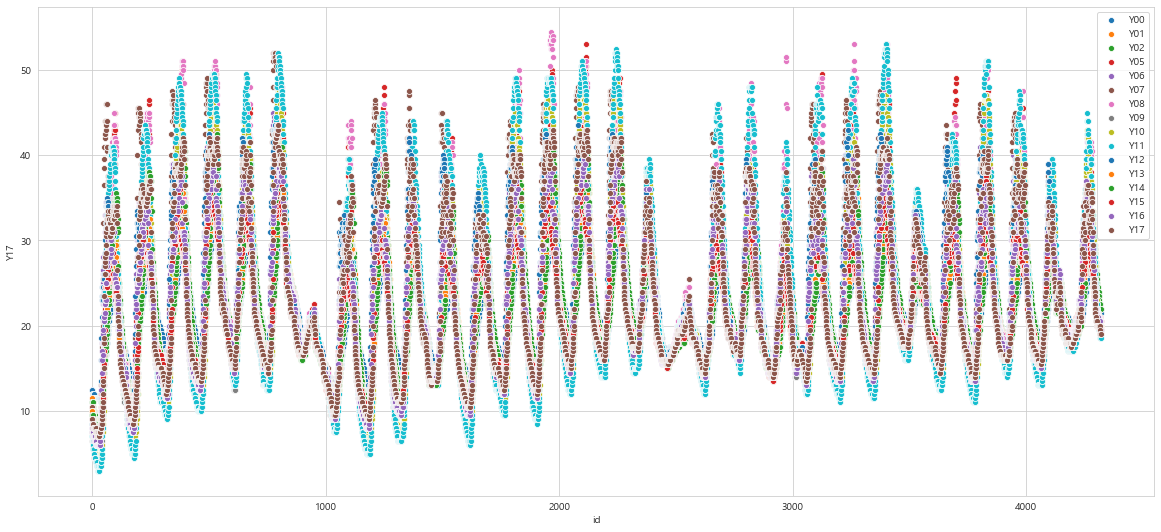

In [20]:
plt.figure(figsize = (20,9))
for i in range(18):
    try:
        sns.scatterplot(train.index , train['Y%02d'%i] , label = 'Y' + '%02d'%i)
    except:
        pass
plt.legend()
plt.show()

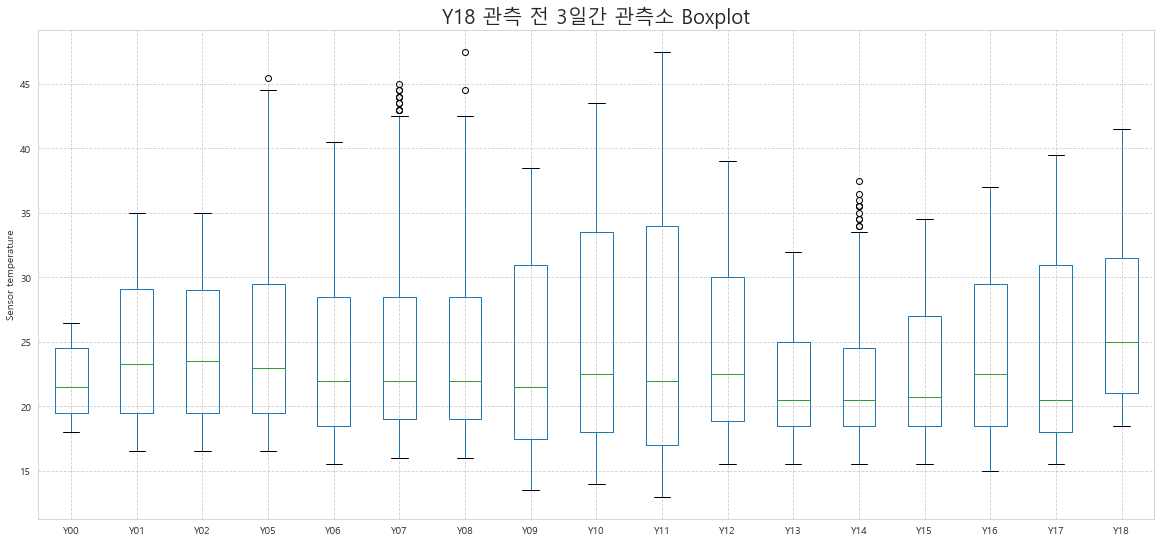

In [21]:
train.loc[3888:, 'Y00':'Y18'].plot.box(figsize = (20,9))
plt.title('Y18 관측 전 3일간 관측소 Boxplot' , fontsize = 20)
plt.ylabel('Sensor temperature')
plt.grid(linestyle = '--')
plt.show()

○ 총 데이터는 33일치가 주어졌지만 , 주어진 데이터에서는 Y18값은 고작 3일치밖에 존재하지 않았다. 나머지30일은 Y18이 결측값이므로
 
   Y00~Y17을 통해 Y18의 값을 대체시켜줘야함 . 그러기 위해서 최대한 Y18과 비슷한 데이터를 추려내려고 함.

   그래서 Y18값이 주어진 3일과 가장 가까운 3일 데이터만 확인함.

○ Y18은 일교차가 비교적 적은편임을 알 수 있다. 
   그리고 , 중간값과 최저온도 또한 큰 차이가 없다는 점을 알 수 있다.

○ 이상치가 존재하는 값들이 많으므로 , Y18이 NaN인 행들에 Y18값 대체값을 생성해줄때
   Y00~Y17의 평균보다는 중간값이 더 적절하다고 판단됨

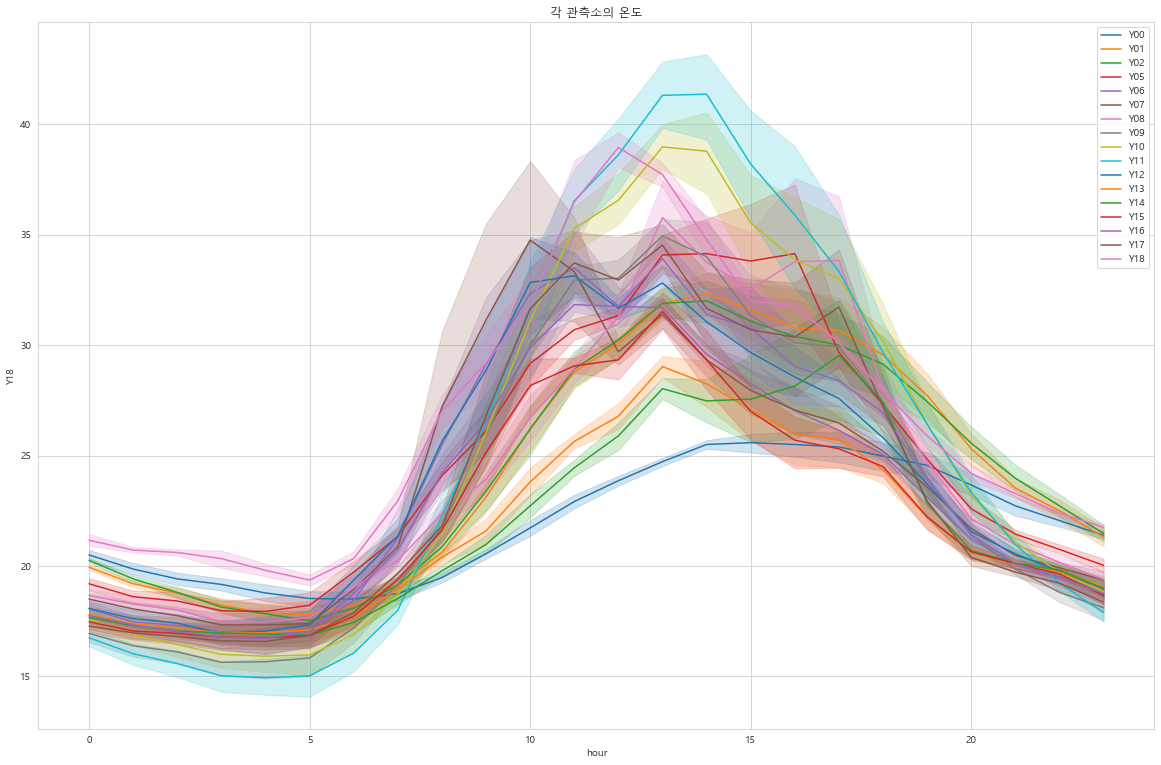

In [22]:
plt.figure(figsize = (20,13))
plt.subplot(111)
plt.title('각 관측소의 온도')
plt.ylabel('Temperature')

#Y00~ Y17데이터의 TRAIN 마지막 3일치 데이터
for i in range(18):
    try:
        sns.lineplot(x="hour", y="Y%02d"%i, data = train[3888:] , label='Y%02d'%i)
    except:
        pass


#Y18데이터(3일치 데이터)
sns.lineplot(x="hour", y="Y18", data = train[4320:] , label='Y18')

plt.legend()
plt.grid(True)


plt.show()

# Feature engineering 

#### ○ Y18이 결측치인 4320개의 행은 Y00~ Y17 센서변수들의 중간값으로 대체시켜줌

In [23]:
train['Y18'] = train[sensor_col].median(axis=1)


#Y18을 제외한 Y00~Y17 센서 관측치 중간값으로 대체 후 삭제
sensor_col.remove('Y18')
train.drop(sensor_col , axis =1  ,inplace = True)  

train.head()

,기온01,기온02,기온03,기온04,기온05,현지기압01,현지기압02,현지기압03,현지기압04,현지기압05,...,습도04,습도05,풍향01,풍향02,풍향03,풍향04,풍향05,Y18,time,hour
id,,,,,,,,,,,,,,,,,,,,,
0,9.7,12.2,12.3,8.2,10.7,988.8,989.6,1002.5,1008.7,1001.6,...,77.2,62.6,71.3,101.1,56.1,2.3,256.4,9.75,00:00,0
1,9.3,12.1,12.1,8.3,10.3,988.9,989.6,1002.5,1008.7,1001.7,...,77.3,63.5,121.8,165.3,0.0,0.0,215.4,9.50,00:10,0
2,9.4,12.1,12.1,8.0,9.7,989.0,989.7,1002.4,1008.6,1001.6,...,77.3,63.9,232.0,144.0,0.0,0.0,235.2,9.00,00:20,0
3,9.4,12.0,12.1,7.7,9.4,988.9,989.6,1002.4,1008.7,1001.5,...,77.5,64.5,0.0,115.9,294.1,0.0,214.0,9.00,00:30,0
4,9.2,12.0,12.0,7.4,9.4,988.9,989.7,1002.4,1008.7,1001.5,...,78.0,65.0,0.0,124.7,0.0,0.0,174.9,8.50,00:40,0


#### ○ 위치별로 값이 비슷한 기상청 변수들을 평균내줌

In [24]:
mean_column = ['기온', '일일누적일사량', '습도' , '일일누적강수량','현지기압']

In [25]:
for col in mean_column:      #mean_column list변수들 값들을 평균내주고 , 기존5개의 값은 제거해줌
    
    train.loc[:,col] = train[list(train.columns[train.columns.str.contains(col)])].mean(axis=1)
    test.loc[:,col] = test[list(test.columns[test.columns.str.contains(col)])].mean(axis=1)

        
    for j in range(1,6):
        try:
            train.drop(col + '%02d'%j, axis = 1 , inplace = True) 
            test.drop(col + '%02d'%j, axis = 1 , inplace = True)
        except:              #누적일사량02, 03 , 04값이 없음으로 인해 나타나는 오류 방지
            pass                                                    
        
train.head()

,풍속01,풍속02,풍속03,풍속04,풍속05,풍향01,풍향02,풍향03,풍향04,풍향05,Y18,time,hour,기온,일일누적일사량,습도,일일누적강수량,현지기압
id,,,,,,,,,,,,,,,,,,
0,1.2,0.6,0.3,1.1,0.5,71.3,101.1,56.1,2.3,256.4,9.75,00:00,0,10.62,0.0,76.46,0.0,998.24
1,1.7,1.9,0.4,0.0,0.0,121.8,165.3,0.0,0.0,215.4,9.50,00:10,0,10.42,0.0,76.84,0.0,998.28
2,1.1,2.3,0.6,0.0,0.0,232.0,144.0,0.0,0.0,235.2,9.00,00:20,0,10.26,0.0,78.42,0.0,998.26
3,1.5,0.7,0.1,0.0,0.2,0.0,115.9,294.1,0.0,214.0,9.00,00:30,0,10.12,0.0,79.26,0.0,998.22
4,0.8,1.7,0.0,0.0,0.0,0.0,124.7,0.0,0.0,174.9,8.50,00:40,0,10.00,0.0,80.06,0.0,998.24


○ 풍속의 평균값은 온도예측에 유의미한 변수라고 생각 해 볼 수 있다.(강풍이 불면 비교적 온도가 낮을거라 생각)

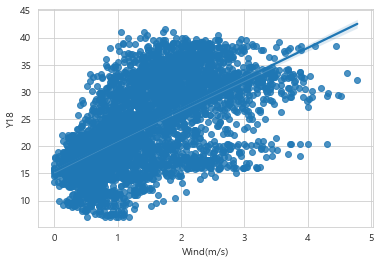

In [26]:
train['풍속'] = train[['풍속%02d'%i for i in range(1,6)]].mean(axis=1)
test['풍속'] = test[['풍속%02d'%i for i in range(1,6)]].mean(axis=1)

sns.regplot('풍속' ,'Y18' ,data = train)
plt.xlabel('Wind(m/s)')
plt.show()

#### ○ 풍속의 데이터 분석

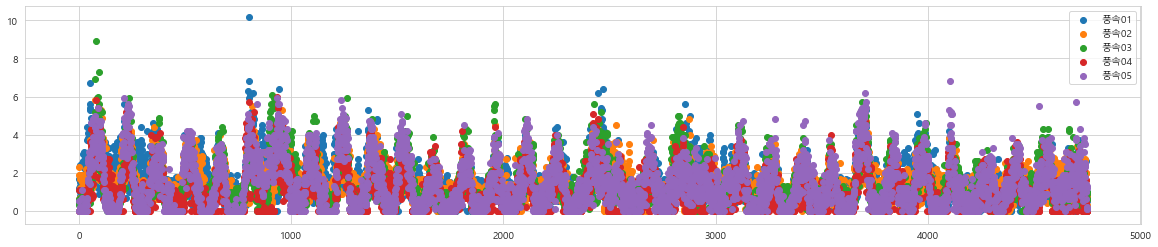

In [27]:
plt.figure(figsize=(20,4))
for i in range(1,6):
    plt.scatter(train.index, train['풍속%02d'%i] , label = '풍속%02d'%i)
plt.legend()
plt.show()

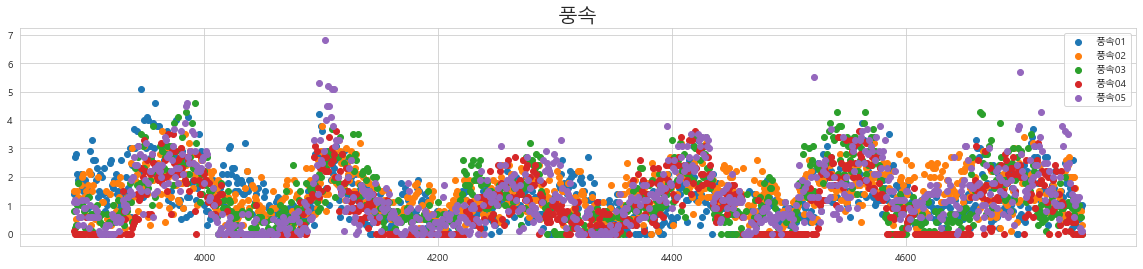

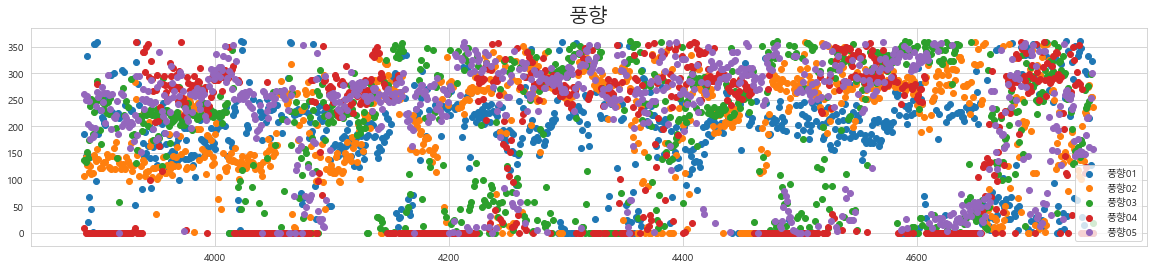

In [28]:
#너무 데이터가 많으므로 , Y18관측데이터 3일 전 시점부터 확인
plt.figure(figsize=(20,4))
for i in range(1,6):
    plt.scatter(train[3888:].index, train.loc[3888:,'풍속%02d'%i] , label = '풍속%02d'%i)
plt.legend()
plt.title('풍속', fontsize = 20)




plt.figure(figsize=(20,4))
for i in range(1,6):
    plt.scatter(train[3888:].index, train.loc[3888:,'풍향%02d'%i] , label = '풍향%02d'%i)
plt.legend()
plt.title('풍향', fontsize = 20)

plt.show()


○ 풍속과 풍향이 정확히 0인 데이터가 비교적 많음을 알 수 있다.
   이러한 데이터를 집중적으로 분석해보기로 함

In [29]:
for i in ['풍속%02d'%i for i in range(1,6)]:
    print(10*'-',i, '값이 0일때 각 풍향의 평균값 \n',train[train[i]==0][['풍향%02d'%i for i in range(1,6)]].mean())

---------- 풍속01 값이 0일때 각 풍향의 평균값 
 풍향01    167.162462
풍향02      0.000000
풍향03    120.229538
풍향04     65.616308
풍향05    185.340000
dtype: float64
---------- 풍속02 값이 0일때 각 풍향의 평균값 
 풍향01    150.485016
풍향02    156.820847
풍향03     99.093485
풍향04     54.572964
풍향05     51.086319
dtype: float64
---------- 풍속03 값이 0일때 각 풍향의 평균값 
 풍향01      0.00000
풍향02    158.54175
풍향03     98.24450
풍향04     61.19400
풍향05    186.22650
dtype: float64
---------- 풍속04 값이 0일때 각 풍향의 평균값 
 풍향01    165.948984
풍향02    164.057770
풍향03    110.326085
풍향04      0.000000
풍향05    177.331192
dtype: float64
---------- 풍속05 값이 0일때 각 풍향의 평균값 
 풍향01    165.685678
풍향02    154.686189
풍향03      0.000000
풍향04     58.375192
풍향05    192.091816
dtype: float64


풍속01 ↔ 풍향02

풍속02 ↔ 풍향05

풍속03 ↔ 풍향01

풍속04 ↔ 풍향04

풍속05 ↔ 풍향03

위에서 보면 알수 있듯,  풍속02는 풍향05와 확실히 연관이 있다고 단정지을 수는 없다.
하지만, 나머지 풍속은 확실하므로 , 묶어줄만 하다고 판단함

그래도 이 변수들을 묶는 방법이 마땅치 않은 것 같다.

###  풍속과 풍향 데이터 묶어주기

○ 벡터연산을 위한 풍속과 방향을 결합한 X축과 Y축을 생성해줌

○ 특정 지역의 바람데이터만 사용하고 싶었으나 , 벡터값이라 평균을 낼 수도 없고 , 하나만 빼내기가 애매해서 그냥 모든 변수를 다 사용함.
그리고 모든 데이터를 다 사용해도 점수가 충분히 올랐음을 확인함

In [30]:
import math


def get_x(wind):
    wind_speed = float( wind[0] )
    wind_dir = float( wind[1] )
    return round( wind_speed * math.cos( radia_transform(wind_dir) ), 3)

def get_y(wind ):
    wind_speed = float( wind[0] )
    wind_dir = float( wind[1] )
    return round( wind_speed * math.sin( radia_transform(wind_dir) ), 3)

def radia_transform(degree):
    return degree * math.pi / 180

In [31]:
wind_math_list = [      ['풍속01' , '풍향02'],
                        ['풍속02' , '풍향05'],
                        ['풍속03' , '풍향01'],
                        ['풍속04' , '풍향04'],
                        ['풍속05' , '풍향03']]

In [32]:
for index , match in enumerate(wind_math_list):
    train['풍속%02d'%(index+1)+'_x'] = train[match].apply(lambda x : get_x(x), axis = 1)
    train['풍속%02d'%(index+1)+'_y'] = train[match].apply(lambda x : get_y(x), axis = 1)    
    
    test['풍속%02d'%(index+1)+'_x'] = test[match].apply(lambda x : get_x(x), axis = 1)
    test['풍속%02d'%(index+1)+'_y'] = test[match].apply(lambda x : get_y(x), axis = 1)    
    
train.drop(['풍속%02d'%num for num in range(1,6)], axis = 1, inplace = True)
test.drop(['풍속%02d'%num for num in range(1,6)], axis = 1, inplace = True)

train.drop(['풍향%02d'%num for num in range(1,6)], axis = 1, inplace = True)
test.drop(['풍향%02d'%num for num in range(1,6)], axis = 1, inplace = True)

train.head()

,Y18,time,hour,기온,일일누적일사량,습도,일일누적강수량,현지기압,풍속,풍속01_x,풍속01_y,풍속02_x,풍속02_y,풍속03_x,풍속03_y,풍속04_x,풍속04_y,풍속05_x,풍속05_y
id,,,,,,,,,,,,,,,,,,,
0,9.75,00:00,0,10.62,0.0,76.46,0.0,998.24,0.74,-0.231,1.178,-0.141,-0.583,0.096,0.284,1.099,0.044,0.279,0.415
1,9.50,00:10,0,10.42,0.0,76.84,0.0,998.28,0.80,-1.644,0.431,-1.549,-1.101,-0.211,0.340,0.000,0.000,0.000,0.000
2,9.00,00:20,0,10.26,0.0,78.42,0.0,998.26,0.80,-0.890,0.647,-1.313,-1.889,-0.369,-0.473,0.000,0.000,0.000,0.000
3,9.00,00:30,0,10.12,0.0,79.26,0.0,998.22,0.50,-0.655,1.349,-0.580,-0.391,0.100,0.000,0.000,0.000,0.082,-0.183
4,8.50,00:40,0,10.00,0.0,80.06,0.0,998.24,0.50,-0.455,0.658,-1.693,0.151,0.000,0.000,0.000,0.000,0.000,0.000


## 누적데이터를 활용해 일일 데이터 변수생성


○ 시간이 23:50 -> 00:00 일때 , 누적량이 바로 0으로 변하는 것은 문제가 있다 .

○ 이 점 해결을 위해 time_rain이라는 변수를 생성하였지만  , ARIMA(시계열 분석)를 사용하면 이 문제를 해결 가능해보임.

하지만 일단은 time_rain이라는 변수로 대체하였음.

In [33]:
#ㅡㅡㅡㅡㅡtrain데이터의 누적데이터로 일일데이터 생성

for i in range(len(train)):
    if i ==0:
        train.loc[i,'time_rain']=0
        train.loc[i, 'time_sun']=0
    else:
        if(train.loc[i,'time']=='00:00'):
            train.loc[i,'time_rain'] = train.loc[i,'일일누적강수량']
            train.loc[i,'time_sun'] = train.loc[i,'일일누적일사량']
        else:
            train.loc[i,'time_rain'] = train.loc[i , '일일누적강수량'] - train.loc[i-1 , '일일누적강수량']
            train.loc[i,'time_sun'] = train.loc[i , '일일누적일사량'] - train.loc[i-1 , '일일누적일사량']


train.head()

,Y18,time,hour,기온,일일누적일사량,습도,일일누적강수량,현지기압,풍속,풍속01_x,...,풍속02_x,풍속02_y,풍속03_x,풍속03_y,풍속04_x,풍속04_y,풍속05_x,풍속05_y,time_rain,time_sun
id,,,,,,,,,,,,,,,,,,,,,
0,9.75,00:00,0,10.62,0.0,76.46,0.0,998.24,0.74,-0.231,...,-0.141,-0.583,0.096,0.284,1.099,0.044,0.279,0.415,0.0,0.0
1,9.50,00:10,0,10.42,0.0,76.84,0.0,998.28,0.80,-1.644,...,-1.549,-1.101,-0.211,0.340,0.000,0.000,0.000,0.000,0.0,0.0
2,9.00,00:20,0,10.26,0.0,78.42,0.0,998.26,0.80,-0.890,...,-1.313,-1.889,-0.369,-0.473,0.000,0.000,0.000,0.000,0.0,0.0
3,9.00,00:30,0,10.12,0.0,79.26,0.0,998.22,0.50,-0.655,...,-0.580,-0.391,0.100,0.000,0.000,0.000,0.082,-0.183,0.0,0.0
4,8.50,00:40,0,10.00,0.0,80.06,0.0,998.24,0.50,-0.455,...,-1.693,0.151,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0


In [34]:
#ㅡㅡㅡㅡㅡtest데이터의 누적데이터로 일일데이터 생성

for i in range(len(train) , len(train) + len(test)):
    if i ==0:
        test.loc[i,'time_rain']=0
        test.loc[i, 'time_sun']=0
    else:
        if(test.loc[i,'time']=='00:00'):
            test.loc[i,'time_rain'] = test.loc[i,'일일누적강수량']
            test.loc[i,'time_sun'] = test.loc[i,'일일누적일사량']
        else:
            test.loc[i,'time_rain'] = test.loc[i , '일일누적강수량'] - test.loc[i-1 , '일일누적강수량']
            test.loc[i,'time_sun'] = test.loc[i , '일일누적일사량'] - test.loc[i-1 , '일일누적일사량']
            
test.head()

,time,hour,기온,일일누적일사량,습도,일일누적강수량,현지기압,풍속,풍속01_x,풍속01_y,풍속02_x,풍속02_y,풍속03_x,풍속03_y,풍속04_x,풍속04_y,풍속05_x,풍속05_y,time_rain,time_sun
id,,,,,,,,,,,,,,,,,,,,
4752,00:00,0,19.94,0.0,85.22,0.0,996.18,0.80,-1.413,-0.503,-1.257,-0.330,0.985,-0.489,0.0,0.0,0.081,0.059,0.0,0.0
4753,00:10,0,19.92,0.0,85.52,0.0,996.12,0.64,-1.067,-0.266,-1.191,0.144,0.546,-0.249,0.0,0.0,-0.183,0.237,0.0,0.0
4754,00:20,0,19.90,0.0,85.62,0.0,996.06,0.64,-1.290,0.161,-1.054,-0.574,0.000,0.000,0.0,0.0,0.361,0.600,0.0,0.0
4755,00:30,0,19.72,0.0,86.18,0.0,996.04,0.82,-2.058,1.026,-0.797,-0.070,-0.118,-0.382,0.0,0.0,0.345,0.491,0.0,0.0
4756,00:40,0,19.68,0.0,86.72,0.0,996.08,0.66,-1.094,0.119,-0.669,0.207,-0.422,-0.680,0.0,0.0,0.461,0.527,0.0,0.0


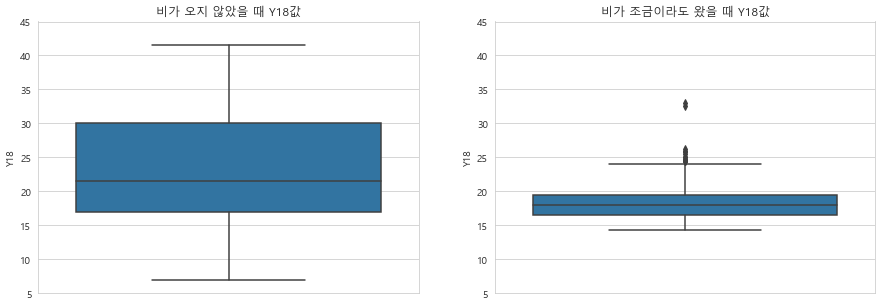

In [35]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title('비가 오지 않았을 때 Y18값')
plt.ylim(5,45)
sns.boxplot(y = 'Y18', data = train[train['time_rain']==0])

plt.subplot(122)
plt.title('비가 조금이라도 왔을 때 Y18값')
plt.ylim(5,45)
sns.boxplot(y = 'Y18', data = train[train['time_rain']>0])

plt.show()

- 비가 온 시기에는 비교적 센서온도(Y18)가 낮음을 확인 할 수 있다.


### ○필요없는 변수들 제거

In [36]:
train.columns

Index(['Y18', 'time', 'hour', '기온', '일일누적일사량', '습도', '일일누적강수량', '현지기압', '풍속',
       '풍속01_x', '풍속01_y', '풍속02_x', '풍속02_y', '풍속03_x', '풍속03_y', '풍속04_x',
       '풍속04_y', '풍속05_x', '풍속05_y', 'time_rain', 'time_sun'],
      dtype='object')

In [37]:
# time 과 hour 둘다 있을 이유가 없음 ..  time을 제거해주기로 함
train.drop('time', axis =1 ,inplace = True)
test.drop('time', axis =1 ,inplace = True)

### ○ time변수 one-hot encoding

In [38]:
train['hour'] = train['hour'].astype('category')
test['hour'] = test['hour'].astype('category')

train = pd.get_dummies(train , columns=['hour'])
test = pd.get_dummies(test , columns=['hour'])

# 데이터 정규화

In [39]:
train_label = train.pop('Y18')
train.head()

,기온,일일누적일사량,습도,일일누적강수량,현지기압,풍속,풍속01_x,풍속01_y,풍속02_x,풍속02_y,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
id,,,,,,,,,,,,,,,,,,,,,
0,10.62,0.0,76.46,0.0,998.24,0.74,-0.231,1.178,-0.141,-0.583,...,0,0,0,0,0,0,0,0,0,0
1,10.42,0.0,76.84,0.0,998.28,0.80,-1.644,0.431,-1.549,-1.101,...,0,0,0,0,0,0,0,0,0,0
2,10.26,0.0,78.42,0.0,998.26,0.80,-0.890,0.647,-1.313,-1.889,...,0,0,0,0,0,0,0,0,0,0
3,10.12,0.0,79.26,0.0,998.22,0.50,-0.655,1.349,-0.580,-0.391,...,0,0,0,0,0,0,0,0,0,0
4,10.00,0.0,80.06,0.0,998.24,0.50,-0.455,0.658,-1.693,0.151,...,0,0,0,0,0,0,0,0,0,0


In [40]:
#더 정확한 정규화를 위해 데이터를 합침
all_data = train.append(test)

all_data_describe_df = all_data.describe().T
all_data_describe_df[:5]

,count,mean,std,min,25%,50%,75%,max
기온,16272.0,24.005472,4.540575,8.30,20.960,24.3600,27.100,35.18
일일누적일사량,16272.0,9.240481,9.625631,0.00,0.025,6.2725,17.515,31.47
습도,16272.0,74.049952,17.469153,19.52,61.755,78.3200,89.100,96.96
일일누적강수량,16272.0,2.129508,6.155113,0.00,0.000,0.0000,0.580,52.64
현지기압,16272.0,996.610982,4.383583,979.54,994.420,996.8700,999.600,1006.98


In [41]:
normed_all_data = (all_data - all_data_describe_df['mean']) / all_data_describe_df['std']

normed_all_data

,기온,일일누적일사량,습도,일일누적강수량,현지기압,풍속,풍속01_x,풍속01_y,풍속02_x,풍속02_y,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
id,,,,,,,,,,,,,,,,,,,,,
0,-2.947968,-0.959987,0.137960,-0.345974,0.371618,-0.643657,-0.138301,0.578618,0.017408,-0.301808,...,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508
1,-2.992016,-0.959987,0.159713,-0.345974,0.380743,-0.579603,-1.240340,0.043351,-1.147920,-0.694676,...,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508
2,-3.027253,-0.959987,0.250158,-0.345974,0.376180,-0.579603,-0.652274,0.198127,-0.952595,-1.292322,...,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508
3,-3.058087,-0.959987,0.298243,-0.345974,0.367055,-0.899870,-0.468991,0.701149,-0.345929,-0.156188,...,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508
4,-3.084515,-0.959987,0.344038,-0.345974,0.371618,-0.899870,-0.313005,0.206009,-1.267101,0.254882,...,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16267,0.337959,0.944304,0.216957,-0.329727,1.165489,1.897127,-0.569601,2.471755,-2.959641,0.660644,...,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,4.795684
16268,0.404030,0.944304,0.086441,-0.329727,1.160927,1.875776,0.254003,1.875582,-2.342216,0.302664,...,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,4.795684
16269,0.373197,0.944304,0.123077,-0.329727,1.170052,2.046585,-0.699850,2.370721,-1.745482,-0.652204,...,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,4.795684


In [42]:
normed_train = normed_all_data[:train.shape[0]]
normed_test = normed_all_data[train.shape[0]:]

print(normed_train.shape , normed_test.shape)

(4752, 42) (11520, 42)


#  학습 데이터셋 생성

In [43]:
train_X = normed_train.sample(frac = 0.8 , random_state=2020)
test_X = normed_train.drop(train_X.index)

train_y = train_label[train_X.index]
test_y = train_label[test_X.index]

obj_X = test

print(train_X.shape , test_X.shape , train_y.shape , test_y.shape)
print('예측하고자 하는 데이터의 행렬 : ', obj_X.shape)

(3802, 42) (950, 42) (3802,) (950,)
예측하고자 하는 데이터의 행렬 :  (11520, 42)


# Modeling

In [44]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score, KFold
import xgboost as xgb
# 데이콘 측에서 주어진 채점방식

def mse_AIFrenz(y_true, y_pred):
    diff = abs(y_true - y_pred)
    less_then_one = np.where(diff < 1, 0, diff)
    score = np.average(np.average(less_then_one ** 2, axis = 0))
    
    return score

scorer = make_scorer(mse_AIFrenz)
cv = KFold(n_splits=6, shuffle = True, random_state=1)

###  hyperopt 사용

In [45]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials


def objective(space):
    
    clf = xgb.XGBRegressor(n_estimators =2500,
                           colsample_bytree=space['colsample_bytree'],
                         learning_rate = space['learning_rate'],
                           max_depth = int(space['max_depth']),
                            min_child_weight = space['min_child_weight'],
                            subsample = space['subsample'],
                           gamma = space['gamma'],
                           reg_lambda = space['reg_lambda'],
                            objective='reg:squarederror'
                          )
    eval_set  = [(train_X, train_y )]

    clf.fit(train_X, train_y,
            eval_set=eval_set, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)

    pred = clf.predict(test_X)
    mse_scr = mse_AIFrenz(test_y, pred)
    print( "SCORE : " + str( np.sqrt(mse_scr) ) )
    return {'loss':mse_scr, 'status': STATUS_OK }


space = {'max_depth': hp.quniform("max_depth", 4, 16, 1),
        'min_child_weight': hp.quniform ('min_child', 1, 10, 1),
        'subsample': hp.uniform ('subsample', 0.7, 1),
        'gamma' : hp.uniform ('gamma', 0, 1),
        'colsample_bytree' : hp.uniform ('colsample_bytree', 0.7,1),
        'reg_lambda' : hp.uniform ('reg_lambda', 0,1),
         'learning_rate' : hp.uniform('learning_rate', 0.06, 0.13)
}

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print( best)   #최적의 파라미터 출력

SCORE : 0.6408903607944969                                                                                             
SCORE : 0.6307320741097021                                                                                             
SCORE : 0.6182308187587563                                                                                             
SCORE : 0.6402520985425988                                                                                             
SCORE : 0.6030421107733724                                                                                             
SCORE : 0.6287998967678964                                                                                             
SCORE : 0.6019751177235798                                                                                             
SCORE : 0.6057981846472196                                                                                             
SCORE : 0.5866841560901442              

In [46]:
best['max_depth'] = int(best['max_depth'])      #max_depth는 int형이 아니면 오류가 나는데 , 이를 해결위한 과정


#위 학습에서 구한 최적의 파라미터들을 사용
XGB_Best = xgb.XGBRegressor(**best, objective='reg:squarederror')
XGB_Best.fit(train_X, train_y) #학습

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9237042256581334,
             gamma=0.3442603729378159, importance_type='gain',
             learning_rate=0.07580022570473902, max_delta_step=0, max_depth=14,
             min_child=6.0, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=0.13095788565303634,
             scale_pos_weight=1, seed=None, silent=None,
             subsample=0.9744811452484344, verbosity=1)

In [52]:
predict_score = np.round(np.mean(cross_val_score(XGB_Best , normed_train, train_label , scoring = scorer , cv = cv )),5)
predict_score

0.36248

# feature importance 

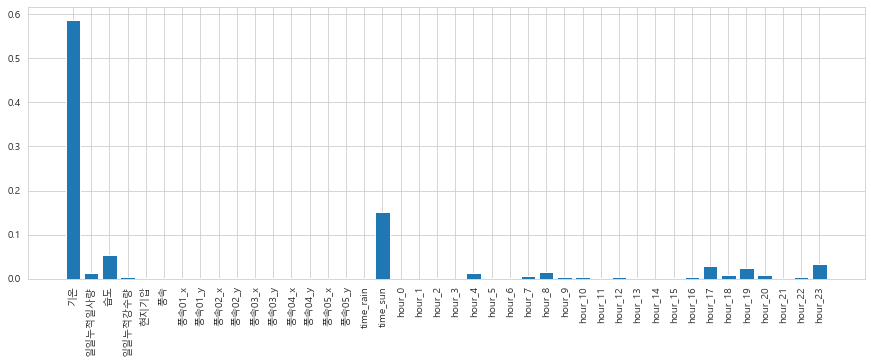

In [48]:
plt.figure(figsize = (15,5))
plt.bar(obj_X.columns ,XGB_Best.feature_importances_)
plt.xticks(rotation = 90)
plt.show()

#당연하겠지만 , 기온이 가장 중요한 변수 , 일조량 또한 중요한 변수로 나타난다 . 

# 제출 

In [49]:
normed_test.head()

,기온,일일누적일사량,습도,일일누적강수량,현지기압,풍속,풍속01_x,풍속01_y,풍속02_x,풍속02_y,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
id,,,,,,,,,,,,,,,,,,,,,
4752,-0.895365,-0.959987,0.639416,-0.345974,-0.098317,-0.579603,-1.060177,-0.625911,-0.906247,-0.109924,...,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508
4753,-0.899770,-0.959987,0.656589,-0.345974,-0.112005,-0.750412,-0.790321,-0.456087,-0.851622,0.249573,...,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508
4754,-0.904174,-0.959987,0.662313,-0.345974,-0.125692,-0.750412,-0.964245,-0.150118,-0.738234,-0.294982,...,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508
4755,-0.943817,-0.959987,0.694370,-0.345974,-0.130255,-0.558252,-1.563231,0.469702,-0.525529,0.087269,...,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508
4756,-0.952626,-0.959987,0.725281,-0.345974,-0.121130,-0.729061,-0.811379,-0.180214,-0.419590,0.297355,...,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508,-0.208508


In [50]:
submission['Y18'] = XGB_Best.predict(normed_test)
submission.to_csv('Dacon_Temperature{}.csv'.format(predict_score))
submission.head()

,Y18
id,
4752,20.247972
4753,20.121004
4754,20.063890
4755,19.153133
4756,19.578514


LSTM 을 활용하여 학습시켰다면 더 좋은 결과가 나왔을 것 같지만, 아직 LSTM 모델링이 잘 안되어서 점수가 잘 나오지 않아 XGBOOST를 사용함